## <font color='darkblue'>Como Fazer a Otimização de Markowitz e a Fronteira Eficiente Com o Python
### <font color='darkblue'> Documentação Yfinance, Pandas, Pandas_datareader, Numpy, Datetime, Scipy.optimize e Matplotlib 
https://pypi.org/project/yfinance/
   
https://pypi.org/project/pandas/
    
https://pypi.org/project/pandas-datareader/   
    
https://numpy.org/pt/
    
https://docs.python.org/pt-br/3/library/datetime.html
    
https://pypi.org/project/scikit-optimize/
         
https://matplotlib.org/stable/index.html

### <font color='darkblue'>Link da Aula, Para Acompanhamento    
https://www.youtube.com/watch?v=BchQuTJvRAs&list=PLQkgHGk8rux6L42KC9l6R25AD7iimkLi_&index=5

In [ ]:
# Instalar as bibliotecas abaixo:
# !pip install yfinance
# !pip install pandas
# !pip install pandas_datareader
# !pip install numpy
# !pip install datetime
# !pip install scipy
# !pip install matplotlib
# Para olhar se a biblioteca já está instalada, deve-se ir no Prompet do Anaconda e digitar: pip freeze

In [2]:
# Importar as bibliotecas

# Essa biblioteca efetua análise de dados financeiros utilizando a linguagem de programação Python.
import yfinance as yf  

# Essa biblioteca é código aberto (open source), construída sobre a linguagem Python, e que providencia 
# uma abordagem rápida e flexível, com estruturas robustas para se trabalhar com dados relacionais (ou rotulados)
import pandas as pd  

# A biblioteca pandas-datareader é uma biblioteca do Python para importar dados de diversas fontes por meio do pandas.
from pandas_datareader import data as pdr

# Biblioteca para a linguagem Python com funções para se trabalhar com computação numérica
import numpy as np

# Essa biblioteca efetua manipulação de séries no tempo para data frame
import datetime as dt

# A biblioteca SciPy disponibiliza muitas funcionalidades de computação científica implementadas de forma eficiente, 
# incluindo integração numérica, interpolação, otimização, álgebra linear e Estatística
from scipy.optimize import minimize

# Matplotlib é uma biblioteca Python frequentemente utilizada para ciência de dados. É uma ferramenta de código aberto
# que oferece recursos de plotagem para a criação de gráficos 2D e 3D com visualizações estáticas, animadas e interativas.
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Desativa os warnings
import warnings
warnings.filterwarnings('ignore')

### <font color='darkblue'> Vamos Definir as Tadas e Importar os Ativos (Ações) da Biblioteca Yfinance 

In [4]:
# # O código abaixo vai definir a data desejada
inicio = dt.date(2015, 1, 1)
final = dt.date(2023, 10, 31)

# O código abaixo vai buscar os ativos (Ação) e (Índice de Referência)
lista_acoes = ["WEGE3", "LREN3", "VALE3", "PETR4", "EQTL3", "EGIE3"]

# O código abaixo vai fazer uma List Comprehension (Somar o nome da ação com ".SA") 
# (Loop) é uma instrução para o programa repetir tarefas 
lista_acoes = [acao + ".SA" for acao in lista_acoes]

# Se quiser listar outras ações
# lista_acoes = ["AAPL", "NKE", "GOOGL", "AMZN"]

# O código abaxio vai pegar o valor de fechamento ajustado dos ativos (Adj Close)
precos = yf.download (lista_acoes, inicio, final)['Adj Close']

# Se tirarmos ['Adj Close'], o código vai trazer todos os campo
# Se quisermos selecionar duas colunas devemos colocar colchetes duplos [['Adj Close', 'Close']]

# Vamos imprimir o Data Frame
precos

[*********************100%***********************]  6 of 6 completed


,EGIE3.SA,EQTL3.SA,LREN3.SA,PETR4.SA,VALE3.SA,WEGE3.SA
Date,,,,,,
2015-01-02,14.337918,4.597056,10.465997,3.318810,12.725253,5.088044
2015-01-05,14.355505,4.421531,10.175044,3.035151,12.533893,5.122736
2015-01-06,14.645690,4.670608,10.292249,2.935871,13.036204,5.046745
2015-01-07,15.015018,4.630489,10.467373,3.074154,13.514600,4.988926
2015-01-08,15.168906,4.597056,10.479785,3.272715,13.658119,5.073177
...,...,...,...,...,...,...
2023-10-23,40.810001,31.450001,12.400000,35.349998,62.560001,33.900002
2023-10-24,40.549999,31.690001,12.380000,35.880001,63.990002,35.009998
2023-10-25,40.230000,31.620001,12.350000,36.070000,63.930000,31.469999


### <font color='darkblue'> Vamos Calcular o Retorno Aritmético e Transformalos em Logarítmo

In [6]:
# O Lambda transforma o retorno aritmédico em logarítimo para facilitar as contas
retornos = precos.pct_change().apply(lambda x: np.log(1+x)).dropna() #retorno logaritmo

# Vamos cálcular a média pra projetar o futuro
media_retornos = retornos.mean()

# Vamos calcular a matriz de covariança par acalcular a volatilidade 
matriz_cov = retornos.cov() 

media_retornos

EGIE3.SA    0.000467
EQTL3.SA    0.000883
LREN3.SA    0.000070
PETR4.SA    0.001079
VALE3.SA    0.000761
WEGE3.SA    0.000833
dtype: float64

### <font color='darkblue'> Vamos Criar 100 Mil Carteiras Para Podermos Calcular Vários Pesos e Volatilidade Para Otimizar a Carteira

In [7]:
numero_carteiras = 100000

# Vamos criar várias tabelas
tabela_retornos_esperados = np.zeros(numero_carteiras)
tabela_volatilidades_esperadas = np.zeros(numero_carteiras)
tabela_sharpe = np.zeros(numero_carteiras)
tabela_pesos = np.zeros((numero_carteiras, len(lista_acoes)))

# Vamos criar a simulação 
for k in range(numero_carteiras):
    
    # Vamos criar os pesos de forma aleanatória
    pesos = np.random.random(len(lista_acoes))
    pesos = pesos/np.sum(pesos)
    tabela_pesos[k, :] = pesos
    
    # Vamos criar a tabela de retorno esperado e a volatilidade
    tabela_retornos_esperados[k] = np.sum(media_retornos * pesos * 252)
    tabela_volatilidades_esperadas[k] = np.sqrt(np.dot(pesos.T, np.dot(matriz_cov*252, pesos)))
    
    # Vamos criar o índice sharpe: o retorno esperado sobre a volatilidade esperada (o melhor retorno sobre a volatilidade)
    tabela_sharpe[k] = tabela_retornos_esperados[k]/tabela_volatilidades_esperadas[k]

### <font color='darkblue'> Vamos Apurar o Índice Ótimo Para Cada Ação 

In [8]:
indice_do_sharpe_maximo = tabela_sharpe.argmax()
tabela_pesos[indice_do_sharpe_maximo]

array([0.06216923, 0.53072501, 0.00062215, 0.06219438, 0.12909471,
       0.21519452])

In [9]:
["WEGE3", "LREN3", "VALE3", "PETR4", "EQTL3", "EGIE3"]

['WEGE3', 'LREN3', 'VALE3', 'PETR4', 'EQTL3', 'EGIE3']

### <font color='darkblue'> Vamos Voltar os Valores dos Retornos Logarítmos em Aritméticos 

In [10]:
tabela_retornos_esperados_arit = np.exp(tabela_retornos_esperados) - 1

### <font color='darkblue'> Vamos Criar a Fronteira Eficiente

In [12]:
eixo_y_fronteira_eficiente = np.linspace(tabela_retornos_esperados_arit.min(), 
                                         tabela_retornos_esperados_arit.max(), 50)

# Função para criar os retornos
def pegando_retorno(peso_teste):
    peso_teste = np.array(peso_teste)
    retorno = np.sum(media_retornos * peso_teste) * 252
    retorno = np.exp(retorno) - 1

    return retorno

# Função para criar os pesos
def checando_soma_pesos(peso_teste):

    return np.sum(peso_teste)-1

# Função para criar os pesos
def pegando_vol(peso_teste):
    peso_teste = np.array(peso_teste)
    vol = np.sqrt(np.dot(peso_teste.T, np.dot(matriz_cov*252, peso_teste)))
    
    return vol

peso_inicial = [1/len(lista_acoes)] * len(lista_acoes) 
limites = tuple([(0, 1) for ativo in lista_acoes])

eixo_x_fronteira_eficiente = []

for retorno_possivel in eixo_y_fronteira_eficiente:
    
    #vamos pegar a melhor volatilidade para cada retorno possível
    
    restricoes = ({'type':'eq', 'fun':checando_soma_pesos},
            {'type':'eq', 'fun': lambda w: pegando_retorno(w) - retorno_possivel})
    
    result = minimize(pegando_vol,peso_inicial,method='SLSQP', bounds=limites, 
                      constraints=restricoes)
    eixo_x_fronteira_eficiente.append(result['fun'])

### <font color='darkblue'> Vamos Plotar Um Gráfico de Dispersão da Fronteira Eficiênte 

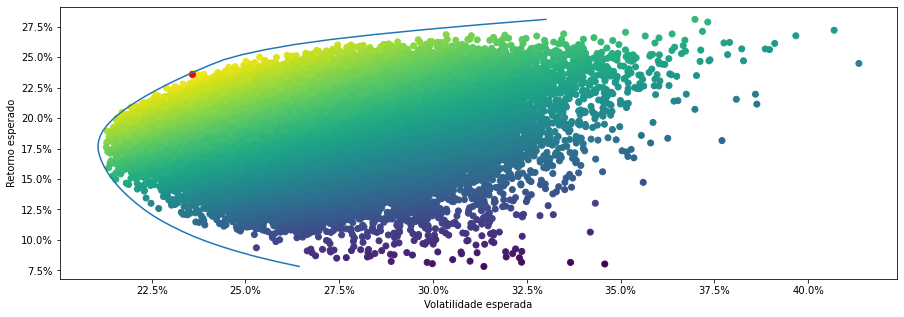

In [20]:
fig, ax = plt.subplots(figsize =(15, 5))


ax.scatter(tabela_volatilidades_esperadas, tabela_retornos_esperados_arit, c = tabela_sharpe)
plt.xlabel("Volatilidade esperada")
plt.ylabel("Retorno esperado")
ax.scatter(tabela_volatilidades_esperadas[indice_do_sharpe_maximo], 
            tabela_retornos_esperados_arit[indice_do_sharpe_maximo], c = "red")
ax.plot(eixo_x_fronteira_eficiente, eixo_y_fronteira_eficiente)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Depois vamos salvar o gráfico em nossa pasta, "plt.savefig('selic.png', dpi = 300)"
plt.savefig('Gráfico de Dispersão da Fronteira de Eficiênte.png', dpi=300)

plt.show()

###### <font color='Red'> Projeto (29/10/2023): Otimização de Markowitz e a Fronteira Eficiente - William E. Santos. 